In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
train_features_file = Path("data/train_features.parquet")
train_df = pl.read_parquet(train_features_file, use_pyarrow=True, memory_map=True)
test_features_file = Path("data/test_features.parquet")
test_df = pl.read_parquet(test_features_file, use_pyarrow=True, memory_map=True)

In [3]:
samples_per_class = 200
random_seed = 42
train_sampled_df = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, seed=random_seed)
        for x in train_df.partition_by("ClassId")
    ]
)

In [4]:
X_train_LBP = np.asarray(train_sampled_df["LBP_Hist"].to_list())
X_test_LBP = np.asarray(test_df["LBP_Hist"].to_list())

In [5]:
X_train_Hue = np.asarray(train_sampled_df["Hue_Hist"].to_list())
X_train_Saturation = np.asarray(train_sampled_df["Saturation_Hist"].to_list())
X_train_Value = np.asarray(train_sampled_df["Value_Hist"].to_list())
X_train_HSV = np.concatenate((X_train_Hue, X_train_Saturation, X_train_Value), axis=1)

X_test_Hue = np.asarray(test_df["Hue_Hist"].to_list())
X_test_Saturation = np.asarray(test_df["Saturation_Hist"].to_list())
X_test_Value = np.asarray(test_df["Value_Hist"].to_list())
X_test_HSV = np.concatenate((X_test_Hue, X_test_Saturation, X_test_Value), axis=1)

In [6]:
X_train_HOG = np.asarray(train_sampled_df["HOG_Features"].to_list())
X_test_HOG = np.asarray(test_df["HOG_Features"].to_list())

In [14]:
X_train = X_train_HOG
X_test = X_test_HOG

In [15]:
y_train = train_sampled_df["ClassId"].to_numpy()
y_test = test_df["ClassId"].to_numpy()

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
svm_classifier = SVC(
    kernel="linear", degree=4, C=1.0, random_state=42
)  # linear, poly, rbf
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9283452098178939


In [19]:
cm = confusion_matrix(y_test, y_pred)

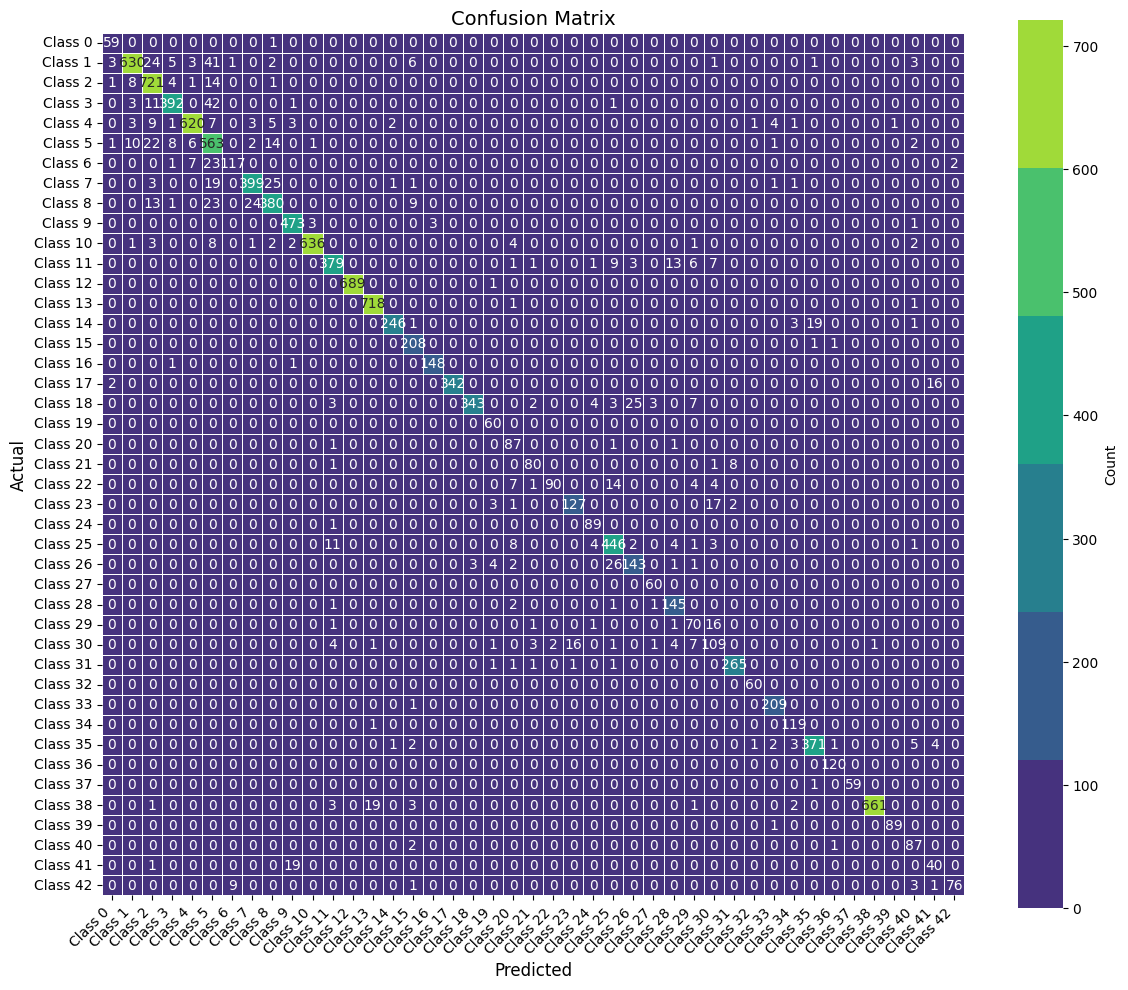

In [20]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]

# Use seaborn's heatmap with a diverging color palette
cmap = ListedColormap(sns.color_palette("viridis"))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()